# GeoDatenErfassung25_HS_Mainz - spaCy Version
Prof. Dr. Yu Feng

**Hinweis:** Dieses Notebook führt die gleichen Analysen wie twitter_analyse.ipynb durch, verwendet aber spaCy statt Stanza für NER.

## 0. Erforderliche Bibliotheken installieren

**Hinweis:** Führen Sie die folgende Zelle aus, um alle benötigten Pakete zu installieren.

Falls Sie in Google Colab arbeiten, sind die meisten Pakete bereits installiert.

In [25]:
# Erforderliche Pakete installieren
# Entfernen Sie die Kommentare (#) vor den Zeilen, um die Pakete zu installieren

# !pip install spacy
# !python -m spacy download en_core_web_lg
# !pip install spacytextblob
# !pip install ijson

# !pip install pandas
# !pip install folium
# !pip install seaborn
# !pip install geopy

print("✓ Pakete können bei Bedarf installiert werden.")
print("✓ spaCy en_core_web_lg Modell erforderlich für NER")
print("✓ spacytextblob für Sentiment-Analyse")

✓ Pakete können bei Bedarf installiert werden.
✓ spaCy en_core_web_lg Modell erforderlich für NER
✓ spacytextblob für Sentiment-Analyse


## 1. Bibliotheken importieren

In [26]:
import json
import ijson
import pandas as pd
import numpy as np
import spacy
import folium
from folium.plugins import MarkerCluster
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim

print("Bibliotheken erfolgreich importiert!")

Bibliotheken erfolgreich importiert!


## 2. JSON-Daten laden und Struktur analysieren

Bitte laden Sie zunächst die Daten herunter!

1. **Daten herunterladen**: Laden Sie die JSON-Datei von folgendem Link herunter:  
   https://seafile.rlp.net/f/19f8815721cd47eea3cc/

2. **Daten speichern**: Legen Sie die heruntergeladene Datei `tweets_europe_west_*.json` im Ordner `data/` ab (im gleichen Verzeichnis wie dieses Notebook).

3. **Für Google Colab**: Falls Sie in Colab arbeiten, laden Sie die Datei hoch oder mounten Sie Google Drive und passen Sie den Dateipfad in der nächsten Zelle entsprechend an.

**Wichtig**: Diese Daten dienen ausschließlich zu Übungszwecken und dürfen nicht ins Internet hochgeladen oder weitergegeben werden.

In [27]:
# Locale Pfad
base_path = ''

In [28]:
# Für Google Colab: Pfad anpassen!
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/Teaching_HS/P0002:1_Datenerfassung/github/GeoDatenErfassung25_HS_Mainz/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# JSON-Datei laden (nur erste 300 Tweets)
file_path = base_path + 'data/tweets_europe_west_600_sample.json'
tweets = []
with open(file_path, 'rb') as f:
    parser = ijson.items(f, 'item')
    for i, tweet in enumerate(parser):
        if i >= 300:
            break
        tweets.append(tweet)

print(f"Geladene Tweets: {len(tweets)}")

Geladene Tweets: 300


In [30]:
# Struktur des ersten Tweets untersuchen
if tweets:
    print("Struktur eines Tweets:")
    print(json.dumps(tweets[2], indent=2, ensure_ascii=False)[:1000])  # Erste 1000 Zeichen

Struktur eines Tweets:
{
  "utc_offset": "-10800",
  "country_code": "ES",
  "text": "Se car el cielo en primavera #Madrid #puertadelsol @ Puerta del Sol Madrid",
  "bounding_box": {
    "type": "Polygon",
    "coordinates": "[[[-3.889005,40.312071],[-3.889005,40.643518],[-3.51801,40.643518],[-3.51801,40.312071]]]"
  },
  "coordinates": "[-3.70352705,40.41705918]",
  "full_name": "Madrid, España",
  "geo": {
    "type": "Point",
    "coordinates": "[40.41705918,-3.70352705]"
  },
  "name": "Madrid",
  "lang": "es",
  "country": "España",
  "created_at": "Tue May 10 19:17:11 +0000 2016",
  "time_zone": "Santiago",
  "place_type": "city",
  "timestamp_ms": "1462907831787",
  "location": "Santiago, Chile"
}


In [31]:
# Wichtige Felder extrahieren
print("Verfügbare Hauptfelder:")
if tweets:
    for key in tweets[0].keys():
        print(f"  - {key}")

Verfügbare Hauptfelder:
  - utc_offset
  - country_code
  - text
  - bounding_box
  - coordinates
  - full_name
  - geo
  - name
  - lang
  - country
  - created_at
  - time_zone
  - place_type
  - timestamp_ms
  - location


## 3. Daten in DataFrame konvertieren

In [32]:
# Relevante Informationen extrahieren
data = []
for tweet in tweets:
    item = {
        'text': tweet.get('text', ''),
        'created_at': tweet.get('created_at', ''),
        'user_location': tweet.get('user', {}).get('location', ''),
        'coordinates': tweet.get('coordinates', None),
        'place': tweet.get('place', None),
        'lang': tweet.get('lang', '')
    }

    # Geo-Koordinaten extrahieren (vom Benutzer bereitgestellte Position)
    # Format: "[-4.46483776,36.72159228]" (JSON-Array als String)
    coords_str = tweet.get('coordinates', None)
    if coords_str:
        try:
            # String-Format parsen
            coords = json.loads(coords_str) if isinstance(coords_str, str) else coords_str
            if coords and isinstance(coords, list) and len(coords) == 2:
                item['longitude'] = coords[0]
                item['latitude'] = coords[1]
        except:
            pass

    # Place-Informationen extrahieren
    place_obj = tweet.get('place', None)
    if place_obj and isinstance(place_obj, dict):
        item['place_name'] = place_obj.get('full_name', '')
        item['country'] = place_obj.get('country', '')

    data.append(item)

df = pd.DataFrame(data)
print(f"DataFrame erstellt mit {len(df)} Eintraegen")
print(f"Tweets mit Standort-Koordinaten: {df['longitude'].notna().sum() if 'longitude' in df.columns else 0}")
df.head()

DataFrame erstellt mit 300 Eintraegen
Tweets mit Standort-Koordinaten: 300


,text,created_at,user_location,coordinates,place,lang,longitude,latitude
0,"Un toque de locura nunca viene mal, pues eso, ...",Tue May 10 19:17:11 +0000 2016,,"[-4.46483776,36.72159228]",None,es,-4.464838,36.721592
1,Motion de censure : Valls ne «craint» pas le r...,Tue May 10 19:17:11 +0000 2016,,"[2.2892648,48.8249147]",None,fr,2.289265,48.824915
2,Se car el cielo en primavera #Madrid #puertade...,Tue May 10 19:17:11 +0000 2016,,"[-3.70352705,40.41705918]",None,es,-3.703527,40.417059
3,lovely to visit thanks for coming,Tue May 10 19:17:11 +0000 2016,,"[-6.24724667,53.33875333]",None,en,-6.247247,53.338753
4,"Desnudo como Adán el primer día @ Rome, Italy",Tue May 10 19:17:12 +0000 2016,,"[12.5,41.9]",None,es,12.500000,41.900000


In [33]:
# Statistiken anzeigen
print("\nDatensatz-Übersicht:")
if 'latitude' in df.columns and 'longitude' in df.columns:
    print(f"Tweets mit Standort-Koordinaten: {df['latitude'].notna().sum()}")
else:
    print(f"Tweets mit Standort-Koordinaten: 0")
print(f"Tweets mit Place-Info: {df['place_name'].notna().sum() if 'place_name' in df.columns else 0}")
print(f"Tweets mit User-Location: {df['user_location'].notna().sum()}")
print(f"\nSprachverteilung:")
print(df['lang'].value_counts())


Datensatz-Übersicht:
Tweets mit Standort-Koordinaten: 300
Tweets mit Place-Info: 0
Tweets mit User-Location: 300

Sprachverteilung:
lang
en     123
es      50
und     21
nl      20
ru      15
fr      12
de      12
it      11
sv       6
pt       5
cs       3
pl       3
fi       3
lv       2
ar       2
tr       2
uk       2
is       2
da       1
no       1
ro       1
tl       1
lt       1
eu       1
Name: count, dtype: int64


## 4. spaCy NER Model laden

In [34]:
# spaCy NER Model laden
print("Lade spaCy NER-Modell für Englisch...")

try:
    # Versuche, das Modell zu laden
    nlp = spacy.load('en_core_web_lg')
    print("✓ spaCy NER-Modell erfolgreich geladen!")
except:
    print("⚠ Modell nicht gefunden. Bitte installieren Sie es mit:")
    print("  python -m spacy download")
    nlp = None

Lade spaCy NER-Modell für Englisch...
✓ spaCy NER-Modell erfolgreich geladen!


In [35]:
# Pipeline-Informationen anzeigen
if nlp:
    print(f"Pipeline-Komponenten: {nlp.pipe_names}")
    print("Sprache: Englisch")

Pipeline-Komponenten: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']
Sprache: Englisch


## 5. NER auf Tweets anwenden

In [36]:
# Test: spaCy NER auf einem einfachen Satz testen
if nlp:
    test_text = "I love visiting Paris and London in Europe."
    print(f"Test-Text: {test_text}")
    print(f"\nTest NER mit spaCy...")

    try:
        doc = nlp(test_text)
        print(f"✓ Text erfolgreich verarbeitet")

        entities = []
        for ent in doc.ents:
            entities.append((ent.text, ent.label_))

        print(f"✓ Gefundene Entities: {len(entities)}")

        if entities:
            print(f"\nExtrahierte Entities:")
            for text, label in entities:
                print(f"  - {text} ({label})")
        else:
            print("\n⚠ Keine Entities gefunden!")
    except Exception as e:
        print(f"✗ FEHLER: {str(e)}")
        import traceback
        traceback.print_exc()

Test-Text: I love visiting Paris and London in Europe.

Test NER mit spaCy...
✓ Text erfolgreich verarbeitet
✓ Gefundene Entities: 3

Extrahierte Entities:
  - Paris (GPE)
  - London (GPE)
  - Europe (LOC)


In [37]:
# NER auf englische Tweets anwenden
def extract_entities(text, nlp_model):
    """Extrahiert Named Entities aus einem Text mit spaCy"""
    if not text or not isinstance(text, str) or len(text.strip()) == 0:
        return []

    try:
        # NER mit spaCy durchführen
        doc = nlp_model(text)
        entities = []
        for ent in doc.ents:
            entities.append({
                'text': ent.text,
                'type': ent.label_
            })
        return entities
    except:
        return []

# Auf englische Tweets anwenden
english_tweets = df[df['lang'] == 'en'].copy()
print(f"Anzahl englischer Tweets: {len(english_tweets)}")

if len(english_tweets) > 0 and nlp:
    print("\nNER wird angewendet (dies kann einige Zeit dauern)...")
    english_tweets['entities'] = english_tweets['text'].apply(lambda x: extract_entities(x, nlp))
    print("NER-Extraktion abgeschlossen!")

Anzahl englischer Tweets: 123

NER wird angewendet (dies kann einige Zeit dauern)...
NER-Extraktion abgeschlossen!


In [38]:
# Beispiele von extrahierten Entitaeten anzeigen
if len(english_tweets) > 0:
    print("Beispiele extrahierter Entitaeten:\n")
    for idx, row in english_tweets.head(5).iterrows():
        if row['entities']:
            print(f"Tweet: {row['text'][:80]}...")
            print(f"Entitaeten: {row['entities']}")
            print()

Beispiele extrahierter Entitaeten:

Tweet: #Sales alert: Residential Sales Consultant -... | IS&amp;S - UK &amp; Ireland | ...
Entitaeten: [{'text': 'Ireland', 'type': 'GPE'}, {'text': 'Sunbury', 'type': 'GPE'}, {'text': 'Surrey', 'type': 'GPE'}]

Tweet: Trend Alert: 'Upton Park'. More trends at #trndnl...
Entitaeten: [{'text': "Upton Park'", 'type': 'FAC'}]

Tweet: Earlier with going #withoutshoes . Check out our Snapchat Story 👻 tomsofficial ....
Entitaeten: [{'text': 'withoutshoes', 'type': 'MONEY'}]

Tweet: Just posted a photo @ Grosseto -Barbanella-...
Entitaeten: [{'text': 'Grosseto', 'type': 'GPE'}]



## 6. Orte aus NER extrahieren und mit Geotags vergleichen

In [39]:
# LOC-Entitäten (Orte) extrahieren
def get_locations(entities):
    """Extrahiert Orts-Entitäten (GPE und LOC)
    LOC = Geographische Orte (Flüsse, Berge, etc.)
    GPE = Geopolitische Entitäten (Städte, Länder, etc.)
    """
    if not entities:
        return []
    return [ent['text'] for ent in entities if ent['type'] in ['LOC', 'GPE']]

if len(english_tweets) > 0:
    english_tweets['ner_locations'] = english_tweets['entities'].apply(get_locations)

    # Tweets mit NER-Orten
    tweets_with_ner_loc = english_tweets[english_tweets['ner_locations'].str.len() > 0]
    print(f"Tweets mit NER-erkannten Orten: {len(tweets_with_ner_loc)}")

    # Tweets mit Geotags
    if 'latitude' in english_tweets.columns and 'longitude' in english_tweets.columns:
        tweets_with_geotag = english_tweets[
            english_tweets['latitude'].notna() & english_tweets['longitude'].notna()
        ]
    else:
        tweets_with_geotag = pd.DataFrame()
    print(f"Tweets mit Geotags: {len(tweets_with_geotag)}")

    # Tweets mit beiden
    if len(tweets_with_geotag) > 0:
        tweets_both = english_tweets[
            (english_tweets['ner_locations'].str.len() > 0) &
            (english_tweets['latitude'].notna())
        ]
    else:
        tweets_both = pd.DataFrame()
    print(f"Tweets mit NER-Orten UND Geotags: {len(tweets_both)}")

Tweets mit NER-erkannten Orten: 35
Tweets mit Geotags: 123
Tweets mit NER-Orten UND Geotags: 35


In [40]:
# 5 Beispiele von Tweets mit erkannten Orten anzeigen
if len(english_tweets) > 0:
    print("=== 5 BEISPIELE: TWEETS MIT NER-ERKANNTEN ORTEN ===\n")

    # Tweets mit erkannten Orten filtern
    tweets_with_locs = english_tweets[english_tweets['ner_locations'].str.len() > 0]

    if len(tweets_with_locs) > 0:
        for i, (idx, row) in enumerate(tweets_with_locs.head(5).iterrows(), 1):
            print(f"--- BEISPIEL {i} ---")
            print(f"Original-Text:")
            print(f"  {row['text'][:150]}...")
            print(f"\nErkannte Orte (LOC/GPE):")
            for loc in row['ner_locations']:
                print(f"  - {loc}")
            print(f"\nAlle Entitaeten:")
            for ent in row['entities']:
                print(f"  - {ent['text']} ({ent['type']})")
            print("\n")
    else:
        print("Keine Tweets mit erkannten Orten gefunden.")

=== 5 BEISPIELE: TWEETS MIT NER-ERKANNTEN ORTEN ===

--- BEISPIEL 1 ---
Original-Text:
  #Sales alert: Residential Sales Consultant -... | IS&amp;S - UK &amp; Ireland | #Sunbury, Surrey...

Erkannte Orte (LOC/GPE):
  - Ireland
  - Sunbury
  - Surrey

Alle Entitaeten:
  - Ireland (GPE)
  - Sunbury (GPE)
  - Surrey (GPE)


--- BEISPIEL 2 ---
Original-Text:
  Just posted a photo @ Grosseto -Barbanella-...

Erkannte Orte (LOC/GPE):
  - Grosseto

Alle Entitaeten:
  - Grosseto (GPE)


--- BEISPIEL 3 ---
Original-Text:
  Nec de lege Regia, printed at Paris, see Spondanus, (Annal. Ecclés. A.D. 1443, 1444) has been represented as a certain liquor named camus,...

Erkannte Orte (LOC/GPE):
  - Paris
  - Spondanus

Alle Entitaeten:
  - Regia (ORG)
  - Paris (GPE)
  - Spondanus (LOC)
  - Annal (PERSON)
  - 1444 (DATE)
  - camus (ORG)


--- BEISPIEL 4 ---
Original-Text:
  It's Darg Idol night! (at in Charing Cross, London)...

Erkannte Orte (LOC/GPE):
  - London

Alle Entitaeten:
  - Darg Idol (PERS

## 6.5. Geocoding: NER-Orte in Koordinaten umwandeln

In [41]:
# Geocoding mit Nominatim (OpenStreetMap)
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
import time

# Geocoder initialisieren
geolocator = Nominatim(user_agent="twitter_ner_analysis_spacy")

def geocode_location(location_name, retry=3):
    """Versucht, Koordinaten für einen Ortsnamen zu finden"""
    if not location_name:
        return None, None

    for attempt in range(retry):
        try:
            time.sleep(1)  # Rate limiting
            location = geolocator.geocode(location_name, timeout=10)
            if location:
                return location.latitude, location.longitude
            return None, None
        except (GeocoderTimedOut, GeocoderServiceError):
            if attempt < retry - 1:
                time.sleep(2)
                continue
            return None, None
    return None, None

# NER-Orte geocodieren
if len(english_tweets) > 0 and len(tweets_with_ner_loc) > 0:
    print("Geocoding von NER-Orten (dies kann einige Zeit dauern)...\n")

    # Nur eindeutige Orte geocodieren
    unique_locations = set()
    for locs in english_tweets['ner_locations']:
        unique_locations.update(locs)

    location_coords = {}
    for i, loc in enumerate(unique_locations):
        if i >= 100:  # Limit für mehr Orte
            break
        lat, lon = geocode_location(loc)
        location_coords[loc] = (lat, lon)
        if lat:
            print(f"[OK] {loc}: ({lat:.4f}, {lon:.4f})")
        else:
            print(f"[--] {loc}: Nicht gefunden")

    print(f"\n{len([v for v in location_coords.values() if v[0]])} von {len(location_coords)} Orten erfolgreich geocodiert")

Geocoding von NER-Orten (dies kann einige Zeit dauern)...

[OK] Lauwe: (51.8810, 5.5096)
[OK] SE2 9AQ: (51.5091, 0.1384)
[OK] Dit: (54.7024, -3.2766)
[OK] Hogwarts: (46.5675, 30.7967)
[OK] Iceland: (64.9842, -18.1059)
[OK] Lisbon: (38.7078, -9.1366)
[--] 🇸: Nicht gefunden
[OK] France: (46.6034, 1.8883)
[OK] MO: (38.7605, -92.5618)
[OK] Teralfene: (50.8921, 4.0983)
[OK] Spain: (39.3261, -4.8380)
[OK] Waregem: (50.8868, 3.4324)
[OK] Paris: (48.8589, 2.3200)
[OK] spain: (39.3261, -4.8380)
[--] SPAINtaneousliving: Nicht gefunden
[OK] Hiroshima: (34.3917, 132.4518)
[OK] Ireland: (52.8652, -7.9795)
[OK] London: (51.5074, -0.1278)
[OK] Greece: (38.9954, 21.9877)
[OK] Madrid: (40.4168, -3.7035)
[OK] Grosseto: (42.7751, 11.2878)
[OK] Sunbury: (40.8620, -76.7936)
[--] Spondanus: Nicht gefunden
[OK] Surrey: (51.2715, -0.3415)
[OK] Kinson: (50.7691, -1.9011)
[--] 😜: Nicht gefunden
[OK] Brussels: (50.8466, 4.3517)
[--] justmeandallah: Nicht gefunden
[OK] london: (51.5074, -0.1278)
[OK] Belgium: (50

In [42]:
# Vergleich: NER-Orte vs. Geotag-Orte
if len(english_tweets) > 0:
    print("\n=== VERGLEICH: NER-ORTE vs. GEOTAGS ===\n")

    for idx, row in english_tweets.head(10).iterrows():
        if row['ner_locations'] or row.get('place_name'):
            print(f"Tweet: {row['text'][:60]}...")
            print(f"  NER-Orte: {row['ner_locations']}")
            print(f"  Geotag-Ort: {row.get('place_name', 'N/A')}")
            if 'latitude' in row and pd.notna(row.get('latitude')):
                print(f"  Koordinaten: ({row.get('latitude')}, {row.get('longitude')})")
            print()


=== VERGLEICH: NER-ORTE vs. GEOTAGS ===

Tweet: #Sales alert: Residential Sales Consultant -... | IS&amp;S -...
  NER-Orte: ['Ireland', 'Sunbury', 'Surrey']
  Geotag-Ort: N/A
  Koordinaten: (51.4191935, -0.4191503)

Tweet: Just posted a photo @ Grosseto -Barbanella-...
  NER-Orte: ['Grosseto']
  Geotag-Ort: N/A
  Koordinaten: (42.7719827, 11.10084169)

Tweet: Nec de lege Regia, printed at Paris, see Spondanus, (Annal. ...
  NER-Orte: ['Paris', 'Spondanus']
  Geotag-Ort: N/A
  Koordinaten: (51.5, -0.13)



## 7. Sentiment-Analyse mit spaCy TextBlob

In [43]:
# Sentiment-Analyse mit spacytextblob
try:
    from spacytextblob.spacytextblob import SpacyTextBlob

    # TextBlob zu spaCy Pipeline hinzufügen
    if nlp:
        nlp.add_pipe('spacytextblob')
        print("✓ SpacyTextBlob erfolgreich geladen!")
except:
    print("⚠ SpacyTextBlob nicht verfügbar. Installieren Sie mit: pip install spacytextblob")

✓ SpacyTextBlob erfolgreich geladen!


In [44]:
def analyze_sentiment(text, nlp_model):
    """Analysiert das Sentiment eines Textes mit spaCy TextBlob

    Returns:
        str: 'positive', 'negative', or 'neutral'
    """
    if not text or not isinstance(text, str) or len(text.strip()) == 0:
        return 'neutral'

    try:
        doc = nlp_model(text)
        # TextBlob polarity: -1.0 (negativ) bis 1.0 (positiv)
        polarity = doc._.blob.polarity

        if polarity < -0.1:
            return 'negative'
        elif polarity > 0.1:
            return 'positive'
        else:
            return 'neutral'
    except:
        return 'neutral'

# Sentiment-Analyse auf englische Tweets anwenden
if len(english_tweets) > 0 and nlp:
    print("\nSentiment-Analyse wird durchgefuehrt (dies kann einige Zeit dauern)...")
    english_tweets['sentiment'] = english_tweets['text'].apply(lambda x: analyze_sentiment(x, nlp))
    print("Sentiment-Analyse abgeschlossen!")

    print("\nSentiment-Verteilung:")
    print(english_tweets['sentiment'].value_counts())

    # Beispiele anzeigen
    print("\n=== BEISPIELE FUER VERSCHIEDENE SENTIMENTS ===\n")
    for sentiment_type in ['positive', 'negative', 'neutral']:
        examples = english_tweets[english_tweets['sentiment'] == sentiment_type].head(2)
        if len(examples) > 0:
            print(f"\n{sentiment_type.upper()}:")
            for idx, row in examples.iterrows():
                print(f"  - {row['text'][:100]}...")
            print()


Sentiment-Analyse wird durchgefuehrt (dies kann einige Zeit dauern)...
Sentiment-Analyse abgeschlossen!

Sentiment-Verteilung:
sentiment
neutral     67
positive    41
negative    15
Name: count, dtype: int64

=== BEISPIELE FUER VERSCHIEDENE SENTIMENTS ===


POSITIVE:
  - lovely to visit thanks for coming...
  - Trend Alert: 'Upton Park'. More trends at #trndnl...


NEGATIVE:
  - 20:17 BST: Temperature: 14.4°C, Wind: S, 0 mph (ave), 0 mph (gust), Humidity: 92%, Rain (hourly) 0.0...
  - it's probably nothing but it is as you said. Bad fucking timing. Now we're going to have this ......


NEUTRAL:
  - #Sales alert: Residential Sales Consultant -... | IS&amp;S - UK &amp; Ireland | #Sunbury, Surrey...
  - Earlier with going #withoutshoes . Check out our Snapchat Story 👻 tomsofficial .…...



## 8. Häufigste Orte analysieren

Top 10 häufigste NER-extrahierte Orte:
  Paris: 3
  Madrid: 2
  Greece: 2
  Brussels: 2
  Spain: 2
  Ireland: 1
  Sunbury: 1
  Surrey: 1
  Grosseto: 1
  Spondanus: 1


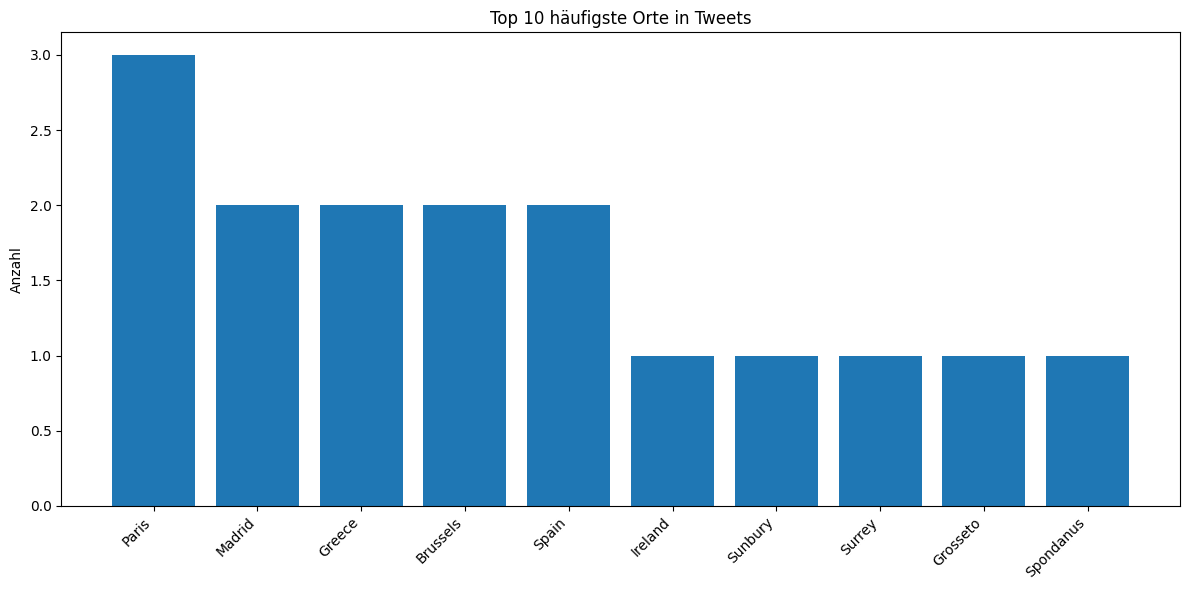

In [45]:
# Top NER-Orte
if len(english_tweets) > 0:
    all_locations = []
    for locs in english_tweets['ner_locations']:
        all_locations.extend(locs)

    if all_locations:
        loc_counter = Counter(all_locations)
        print("Top 10 häufigste NER-extrahierte Orte:")
        for loc, count in loc_counter.most_common(10):
            print(f"  {loc}: {count}")

        # Visualisierung
        top_locs = dict(loc_counter.most_common(10))
        plt.figure(figsize=(12, 6))
        plt.bar(top_locs.keys(), top_locs.values())
        plt.xticks(rotation=45, ha='right')
        plt.title('Top 10 häufigste Orte in Tweets')
        plt.ylabel('Anzahl')
        plt.tight_layout()
        plt.show()

## 9a. Karte 1: Vergleich NER-Orte vs. Geotag-Positionen

In [46]:
# Karte 1: Vergleich NER-Orte (orange Dreiecke) vs. Geotag-Positionen (blaue Kreise)
if len(english_tweets) > 0:
    # Karte zentrieren (Mitteleuropa)
    center_lat = 50.0
    center_lon = 10.0

    # Folium-Karte erstellen
    m1 = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=4,
        tiles='OpenStreetMap'
    )

    # Zwei Layer erstellen
    geotag_layer = MarkerCluster(
        name='Geotag-Positionen (Autor-Standort)',
        show=True,
        options={'maxClusterRadius': 0.1}
    )
    ner_layer = MarkerCluster(
        name='NER-Orte (Text-Erwähnung)',
        show=True,
        options={'maxClusterRadius': 0.1}
    )

    # Tweets mit Geotags UND NER-Locations filtern
    if 'latitude' in english_tweets.columns and 'longitude' in english_tweets.columns:
        tweets_with_geotags = english_tweets[
            (english_tweets['latitude'].notna()) &
            (english_tweets['longitude'].notna()) &
            (english_tweets['ner_locations'].apply(lambda x: len(x) > 0 if isinstance(x, list) else False))
        ].copy()
    else:
        tweets_with_geotags = pd.DataFrame()

    print(f"Karte 1 - NER vs. Geotag Vergleich:")
    print(f"Tweets mit Geotags UND NER-Locations: {len(tweets_with_geotags)}")

    if len(tweets_with_geotags) > 0:
        geotag_added = 0
        ner_added = 0

        for tweet_number, (idx, row) in enumerate(tweets_with_geotags.iterrows(), 1):
            lat = row.get('latitude')
            lon = row.get('longitude')

            if pd.notna(lat) and pd.notna(lon):
                ner_locs = ', '.join(row['ner_locations']) if row.get('ner_locations') else 'Keine'

                # Geotag-Marker (bluer Kreis mit Nummer)
                popup_text = f"""
                GEOTAG-POSITION #{tweet_number}
                Autor-Standort
                NER-Orte im Tweet: {ner_locs}
                Tweet: {row['text']}
                Koordinaten: ({lat:.4f}, {lon:.4f})
                """

                folium.Marker(
                    location=[lat, lon],
                    popup=folium.Popup(popup_text, max_width=350),
                    icon=folium.DivIcon(html=f'''
                        <div style="
                            width: 30px;
                            height: 30px;
                            border-radius: 50%;
                            background-color: blue;
                            border: 2px solid white;
                            display: flex;
                            align-items: center;
                            justify-content: center;
                            font-weight: bold;
                            font-size: 14px;
                            color: white;
                            text-shadow: 1px 1px 2px rgba(0,0,0,0.8);
                        ">{tweet_number}</div>
                    '''),
                    tooltip=f"#{tweet_number} - Geotag"
                ).add_to(geotag_layer)
                geotag_added += 1

                # NER-Marker (orange Dreiecke) - nur für Tweets mit erkannten Orten
                if row.get('ner_locations'):
                    for ner_location in row['ner_locations']:
                        if 'location_coords' in locals() and ner_location in location_coords:
                            ner_lat, ner_lon = location_coords[ner_location]
                            if ner_lat and ner_lon:
                                popup_text = f"""
                                NER-ORT #{tweet_number}
                                Erkannter Ort: {ner_location}
                                Koordinaten: ({ner_lat:.4f}, {ner_lon:.4f})
                                Tweet: {row['text']}
                                """

                                folium.Marker(
                                    location=[ner_lat, ner_lon],
                                    popup=folium.Popup(popup_text, max_width=350),
                                    icon=folium.DivIcon(html=f'''
                                        <div style="position: relative; text-align: center;">
                                            <div style="
                                                width: 0;
                                                height: 0;
                                                border-left: 15px solid transparent;
                                                border-right: 15px solid transparent;
                                                border-top: 30px solid orange;
                                                position: relative;
                                            "></div>
                                            <div style="
                                                position: absolute;
                                                top: 5px;
                                                left: 50%;
                                                transform: translateX(-50%);
                                                font-weight: bold;
                                                font-size: 14px;
                                                color: white;
                                                text-shadow: 1px 1px 2px rgba(0,0,0,0.8);
                                            ">{tweet_number}</div>
                                        </div>
                                    '''),
                                    tooltip=f"#{tweet_number} - {ner_location}"
                                ).add_to(ner_layer)
                                ner_added += 1

        print(f"Marker hinzugefügt:")
        print(f"  - Geotag-Positionen (blau): {geotag_added}")
        print(f"  - NER-Orte (orange): {ner_added}")

    # Layer zu Karte hinzufügen
    geotag_layer.add_to(m1)
    ner_layer.add_to(m1)

    # Layer-Control hinzufügen
    folium.LayerControl(position='topright', collapsed=False).add_to(m1)

    # Legende hinzufügen
    legend_html = '''
    <div style="position:fixed; bottom:50px; right:50px; width:220px;
                background-color:white; border:2px solid grey; z-index:9999;
                padding:10px; font-size:12px;">
    <p style="margin:0 0 8px 0; font-weight:bold;">VERGLEICH: NER vs. GEOTAG</p>
    <p style="margin:5px 0;"><span style="width:20px; height:20px; background-color:blue; border-radius:50%; display:inline-block; border:2px solid white;"></span> Geotag (Autor-Standort)</p>
    <p style="margin:5px 0;">▼ Orange (Erkannter Ort im Text)</p>
    <p style="margin:8px 0 0 0; font-size:10px; color:#666;">
    <b>Unterschied:</b><br>
    - Blau = Wo der Tweet gesendet wurde<br>
    - Orange = Welche Orte erwähnt werden
    </p>
    </div>
    '''
    m1.get_root().html.add_child(folium.Element(legend_html))

    # Speichern
    m1.save(base_path + 'twitter_map_spacy_ner_vs_geotag.html')
    print(f"\n✓ Karte 1 gespeichert: twitter_map_spacy_ner_vs_geotag.html")

    m1
else:
    print("Keine englischen Tweets gefunden!")

Karte 1 - NER vs. Geotag Vergleich:
Tweets mit Geotags UND NER-Locations: 35
Marker hinzugefügt:
  - Geotag-Positionen (blau): 35
  - NER-Orte (orange): 43

✓ Karte 1 gespeichert: twitter_map_spacy_ner_vs_geotag.html


## 9b. Karte 2: Sentiment-Analyse aller Tweets mit Geolokalisierung

In [47]:
# Sentiment-Karte für ALLE Tweets mit Geolokalisierung
category_colors = {
    'positive': 'green',
    'negative': 'red',
    'neutral': 'gray'
}

if len(english_tweets) > 0:
    # Karte zentrieren (Mitteleuropa)
    center_lat = 50.0
    center_lon = 10.0

    # Folium-Karte erstellen
    m2 = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=4,
        tiles='OpenStreetMap'
    )

    # Layer für Sentiment-Marker erstellen
    positive_layer = MarkerCluster(
        name='Sentiment: Positiv ✓',
        show=True,
        options={'maxClusterRadius': 0.1}
    )
    negative_layer = MarkerCluster(
        name='Sentiment: Negativ ✗',
        show=True,
        options={'maxClusterRadius': 0.1}
    )
    neutral_layer = MarkerCluster(
        name='Sentiment: Neutral ○',
        show=True,
        options={'maxClusterRadius': 0.1}
    )

    # Alle Tweets mit Geolokalisierung filtern
    if 'latitude' in english_tweets.columns and 'longitude' in english_tweets.columns:
        tweets_with_geotags = english_tweets[
            english_tweets['latitude'].notna() & english_tweets['longitude'].notna()
        ].copy()
    else:
        tweets_with_geotags = pd.DataFrame()

    print(f"Karte 2 - Sentiment-Analyse:")
    print(f"Tweets mit Geolokalisierung: {len(tweets_with_geotags)}")

    if len(tweets_with_geotags) > 0:
        positive_count = 0
        negative_count = 0
        neutral_count = 0

        for tweet_number, (idx, row) in enumerate(tweets_with_geotags.iterrows(), 1):
            lat = row.get('latitude')
            lon = row.get('longitude')
            sentiment = row.get('sentiment', 'neutral')

            if pd.notna(lat) and pd.notna(lon):
                # NER-Orte extrahieren
                ner_locs = ', '.join(row['ner_locations']) if row.get('ner_locations') else 'Keine Orte erkannt'

                # Popup mit Tweet-Info und Sentiment
                popup_text = f"""
                TWEET #{tweet_number}
                Sentiment: {sentiment.upper()}
                NER-Orte: {ner_locs}
                Text: {row['text']}
                Koordinaten: ({lat:.4f}, {lon:.4f})
                """

                # Farbe basierend auf Sentiment
                color = category_colors.get(sentiment, 'gray')

                # Marker erstellen
                marker = folium.Marker(
                    location=[lat, lon],
                    popup=folium.Popup(popup_text, max_width=350),
                    icon=folium.DivIcon(html=f'''
                        <div style="
                            width: 30px;
                            height: 30px;
                            border-radius: 50%;
                            background-color: {color};
                            border: 2px solid white;
                            display: flex;
                            align-items: center;
                            justify-content: center;
                            font-weight: bold;
                            font-size: 14px;
                            color: white;
                            text-shadow: 1px 1px 2px rgba(0,0,0,0.8);
                        ">{tweet_number}</div>
                    '''),
                    tooltip=f"#{tweet_number} - {sentiment}"
                )

                # Zu entsprechendem Layer hinzufügen
                if sentiment == 'positive':
                    marker.add_to(positive_layer)
                    positive_count += 1
                elif sentiment == 'negative':
                    marker.add_to(negative_layer)
                    negative_count += 1
                else:
                    marker.add_to(neutral_layer)
                    neutral_count += 1

        print(f"Marker hinzugefügt:")
        print(f"  - Positiv (grün): {positive_count}")
        print(f"  - Negativ (rot): {negative_count}")
        print(f"  - Neutral (grau): {neutral_count}")
    else:
        print("Keine Geotags gefunden")

    # Layer zu Karte hinzufügen
    positive_layer.add_to(m2)
    negative_layer.add_to(m2)
    neutral_layer.add_to(m2)

    # Layer-Control hinzufügen
    folium.LayerControl(position='topright', collapsed=False).add_to(m2)

    # Legende hinzufügen
    legend_html = '''
    <div style="position:fixed; bottom:50px; right:50px; width:200px;
                background-color:white; border:2px solid grey; z-index:9999;
                padding:10px; font-size:12px;">
    <p style="margin:0 0 8px 0; font-weight:bold;">SENTIMENT-ANALYSE (spaCy)</p>
    <p style="margin:5px 0;"><span style="width:20px; height:20px; background-color:green; border-radius:50%; display:inline-block; border:2px solid white;"></span> Positiv</p>
    <p style="margin:5px 0;"><span style="width:20px; height:20px; background-color:red; border-radius:50%; display:inline-block; border:2px solid white;"></span> Negativ</p>
    <p style="margin:5px 0;"><span style="width:20px; height:20px; background-color:gray; border-radius:50%; display:inline-block; border:2px solid white;"></span> Neutral</p>
    <p style="margin:8px 0 0 0; font-size:10px; color:#666;">Klicken Sie auf Marker für Tweet-Details</p>
    </div>
    '''
    m2.get_root().html.add_child(folium.Element(legend_html))

    # Speichern und anzeigen
    m2.save(base_path + 'twitter_map_spacy_sentiment.html')
    print(f"\n✓ Karte 2 gespeichert: twitter_map_spacy_sentiment.html")

    m2
else:
    print("Keine englischen Tweets gefunden!")

Karte 2 - Sentiment-Analyse:
Tweets mit Geolokalisierung: 123
Marker hinzugefügt:
  - Positiv (grün): 41
  - Negativ (rot): 15
  - Neutral (grau): 67

✓ Karte 2 gespeichert: twitter_map_spacy_sentiment.html


## 10. Zusammenfassung und Erkenntnisse

In [48]:
if len(english_tweets) > 0:
    print("=== ZUSAMMENFASSUNG DER ANALYSE (spaCy) ===")
    print(f"\nGesamt analysierte englische Tweets: {len(english_tweets)}")
    print(f"Tweets mit NER-Entitäten: {english_tweets['entities'].apply(len).sum()}")

    # Latitude-Spalte pruefen
    if 'latitude' in english_tweets.columns:
        print(f"Tweets mit Geolokalisierung: {english_tweets['latitude'].notna().sum()}")
    else:
        print(f"Tweets mit Geolokalisierung: 0")

    print(f"\nUnterschied NER vs. Geotags:")
    print(f"  - NER erkennt Orte im TEXT der Tweets")
    print(f"  - Geotags zeigen den STANDORT des Autors")
    print(f"  - Diese stimmen oft NICHT überein!")

    if 'sentiment' in english_tweets.columns:
        print(f"\nSentiment-Verteilung (spaCy TextBlob):")
        print(english_tweets['sentiment'].value_counts().to_string())

=== ZUSAMMENFASSUNG DER ANALYSE (spaCy) ===

Gesamt analysierte englische Tweets: 123
Tweets mit NER-Entitäten: 208
Tweets mit Geolokalisierung: 123

Unterschied NER vs. Geotags:
  - NER erkennt Orte im TEXT der Tweets
  - Geotags zeigen den STANDORT des Autors
  - Diese stimmen oft NICHT überein!

Sentiment-Verteilung (spaCy TextBlob):
sentiment
neutral     67
positive    41
negative    15
